# Model to predict the similarity of bugs reported

## Setting up the environment

In [ ]:
! python -m pip install "git+https://github.com/javadba/mpld3@display_fix"

  Cloning https://github.com/javadba/mpld3 (to revision display_fix) to /tmp/pip-req-build-04ea62uj
  Running command git clone --filter=blob:none --quiet https://github.com/javadba/mpld3 /tmp/pip-req-build-04ea62uj
  Running command git checkout -b display_fix --track origin/display_fix
  Switched to a new branch 'display_fix'
  Branch 'display_fix' set up to track remote branch 'display_fix' from 'origin'.
  Resolved https://github.com/javadba/mpld3 to commit 57ed37dbc4749259b1b46cba8bf28de802972adb
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [ ]:
# Importing the necessary modules

import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

# read an excel file and convert into a dataframe object
df = pd.DataFrame(pd.read_excel("/content/better_data_968x968.xlsx"))
df.head()

,Key,Summary,T,Description,Status,P,Resolution,Labels,Components
0,RTYQW-791,[] - KSW_CL - Sourcing from XDEE,Bug,# all expected active credit line from XDEE sh...,Ready for Testing,Critical,NaN,"UAT1, TC1_EEM_CL",XDEE (CLM)
1,RTYQW-746,No data is loaded in GDM tabXDEE after running...,Bug,"+*Desc:*+_x000D_\n 1. The symbol, <>""!, has ca...",Resolved,Critical,Unresolved,_USER,MAS LKJ
2,RTYQW-790,[] - KSW_CL don't see any expected limit group...,Task,List of group limit from KSW_CL live table are...,Resolved,Critical,Unresolved,"EEM_TC1_YYWN, UAT1, TC1_EEM_CL",YYWN
3,RTYQW-581,EEM CCSPD - t_etl_adj_data_KSW_ccspd - Count m...,Improvement,Subject Area: Credit Movement_x000D_\n_x000D_\...,Resolved,Critical,Fixed,GTW,GHYYY (CardLink)
4,RTYQW-535,FRW FILENAME: XXFRWDCXNaabb FRW FIELD: TXN_CCY...,Bug,Subject Area: Credit Movement_x000D_\n_x000D_\...,Resolved,Critical,Fixed,QQQ1,GHYYY (CardLink)


In [ ]:
# Import all the lists: Key, Description

list_of_keys = list(df.Key)
list_of_desc = list(df.Description.backfill())
print(list_of_keys)
print(list_of_desc)

['RTYQW-791', 'RTYQW-746', 'RTYQW-790', 'RTYQW-581', 'RTYQW-535', 'RTYQW-475', 'RTYQW-688', 'RTYQW-539', 'RTYQW-508', 'RTYQW-536', 'RTYQW-726', 'RTYQW-592', 'RTYQW-658', 'RTYQW-537', 'RTYQW-745', 'RTYQW-729', 'RTYQW-712', 'RTYQW-544', 'RTYQW-134', 'RTYQW-107', 'RTYQW-98', 'RTYQW-567', 'RTYQW-358', 'RTYQW-170', 'RTYQW-110', 'RTYQW-129', 'RTYQW-104', 'RTYQW-43', 'RTYQW-42', 'RTYQW-68', 'RTYQW-994', 'RTYQW-922', 'RTYQW-895', 'RTYQW-992', 'RTYQW-391', 'RTYQW-873', 'RTYQW-732', 'RTYQW-959', 'RTYQW-585', 'RTYQW-917', 'RTYQW-912', 'RTYQW-938', 'RTYQW-937', 'RTYQW-1085', 'RTYQW-897', 'RTYQW-779', 'RTYQW-1088', 'RTYQW-803', 'RTYQW-983', 'RTYQW-860', 'RTYQW-933', 'RTYQW-934', 'RTYQW-986', 'RTYQW-798', 'RTYQW-850', 'RTYQW-923', 'RTYQW-792', 'RTYQW-800', 'RTYQW-838', 'RTYQW-871', 'RTYQW-924', 'RTYQW-1086', 'RTYQW-972', 'RTYQW-795', 'RTYQW-545', 'RTYQW-843', 'RTYQW-516', 'RTYQW-872', 'RTYQW-562', 'RTYQW-916', 'RTYQW-975', 'RTYQW-869', 'RTYQW-434', 'RTYQW-528', 'RTYQW-593', 'RTYQW-506', 'RTYQW-324',

In [ ]:
# load nltk's English stopwords as variable called 'stopwords'
nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

## Stemming, tokenizing

*tokenize_and_stem*: tokenizes (splits the synopsis into a list of its
respective words (or tokens)) and also stems each token

*tokenize_only*: tokenizes the synopsis only.

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes

In [ ]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

    print(tokenize_and_stem(list_of_desc[3]))

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of descriptions to create two vocabularies: one stemmed and one only tokenized.

In [ ]:
nltk.download('punkt')

totalvocab_stemmed = []
totalvocab_tokenized = []

# print(list_of_desc[4])
# print("\n____________")
# print(tokenize_and_stem(list_of_desc[4]))
for i in list_of_desc:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [ ]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

## Train and test datsets

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(list_of_desc, list_of_keys, test_size=.1, random_state=1)

I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the synopses list into a tf-idf matrix.

* max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)

* min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.

* ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(x_train)

print(tfidf_matrix.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev'

(870, 8)


In [ ]:
terms = tfidf_vectorizer.get_feature_names_out()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

## K-means clustering

Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose k-means. K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix) #training the model 'km'

clusters = km.labels_.tolist()

CPU times: user 164 ms, sys: 233 µs, total: 164 ms
Wall time: 96.5 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Use joblib.dump to pickle the model, once it has converged and to reload the model/reassign the labels as the clusters.

In [ ]:
import joblib

joblib.dump(km, 'bug_cluster.pkl')

# km = joblib.load('bug_cluster.pkl')
clusters = km.labels_.tolist()

# len(clusters)

I create a dictionary of keys, descriptions, the cluster assignment.

In [ ]:
bugs = {'key': y_train, 'descriptions': x_train, 'cluster': clusters}

frame = pd.DataFrame(bugs, index = [clusters], columns = ['key', 'cluster'])

In [ ]:
# Number of bugs per cluster

frame['cluster'].value_counts()

1    243
4     88
9     80
6     78
8     76
2     73
3     66
7     57
5     56
0     53
Name: cluster, dtype: int64

Indexing and sorting on each cluster to identify which are the top n (I chose n=6) words that are nearest to the cluster centroid. This gives a good sense of the main topic of the cluster.

In [ ]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')

    for ind in order_centroids[i, :10]: #11 words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace

    print("Cluster %d keys:" % i, end='')
    for key in frame.loc[i]['key'].values.tolist():
        print(' %s,' % key, end='')
    print() #add whitespace
    print() #add whitespace

print()
print()

Top terms per cluster:

Cluster 0 words: b'please', b'_x000d_', b'table', b'value', b'field', b'file', b'data', b'mapping',

Cluster 0 keys: RTYQW-253, RTYQW-277, RTYQW-147, RTYQW-759, RTYQW-806, RTYQW-1076, RTYQW-243, RTYQW-564, RTYQW-99, RTYQW-861, RTYQW-855, RTYQW-754, RTYQW-930, RTYQW-255, RTYQW-834, RTYQW-159, RTYQW-1060, RTYQW-839, RTYQW-100, RTYQW-63, RTYQW-115, RTYQW-819, RTYQW-850, RTYQW-840, RTYQW-854, RTYQW-751, RTYQW-271, RTYQW-957, RTYQW-831, RTYQW-97, RTYQW-144, RTYQW-716, RTYQW-1048, RTYQW-931, RTYQW-833, RTYQW-153, RTYQW-154, RTYQW-799, RTYQW-914, RTYQW-651, RTYQW-157, RTYQW-182, RTYQW-897, RTYQW-1073, RTYQW-895, RTYQW-158, RTYQW-778, RTYQW-881, RTYQW-784, RTYQW-908, RTYQW-276, RTYQW-26, RTYQW-824,

Cluster 1 words: b'_x000d_', b'table', b'data', b'please', b'field', b'mapping', b'value', b'file',

Cluster 1 keys: RTYQW-1087, RTYQW-843, RTYQW-318, RTYQW-527, RTYQW-537, RTYQW-387, RTYQW-310, RTYQW-584, RTYQW-424, RTYQW-974, RTYQW-495, RTYQW-492, RTYQW-168, RTYQW-880, RTY

## Multidimensional scaling

Code to convert the dist matrix into a 2-dimensional array using multidimensional scaling.

In [ ]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


## Visualizing document clusters

Visualize the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js).
First I define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.

In [ ]:
#set up colors per clusters using a dict
cluster_colors = {0: 'red', 1: 'blue', 2: 'yellow', 3: 'green', 4: 'brown', 5: 'pink', 6: 'orange', 7: 'grey', 8:'cyan', 9: 'purple'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 1',
                 1: 'Cluster 2',
                 2: 'Cluster 3',
                 3: 'Cluster 4',
                 4: 'Cluster 5',
                 5: 'Cluster 6',
                 6: 'Cluster 7',
                 7: 'Cluster 8',
                 8: 'Cluster 9',
                 9: 'Cluster 10'}

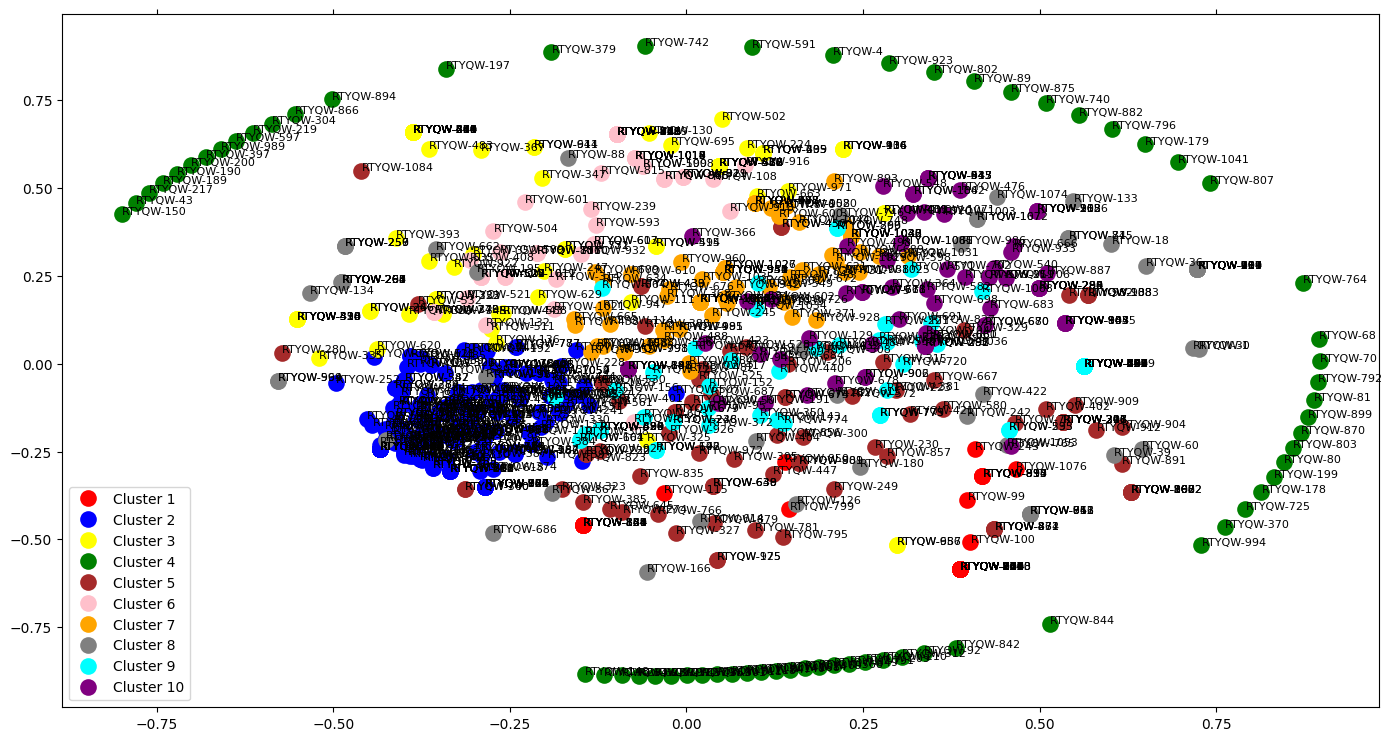

In [ ]:
%matplotlib inline

#create data frame that has the result of the MDS plus the cluster numbers and titles
df_2 = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=y_train))

#group by cluster
groups = df_2.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_names[name], color=cluster_colors[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df_2)):
    ax.text(df_2.loc[i]['x'], df_2.loc[i]['y'], df_2.loc[i]['title'], size=8)



plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)